
===================== [AutoML - GPP] =====================


,Description,Value
0,Session id,42
1,Target,GPP
2,Target type,Regression
3,Original data shape,"(85914, 16)"
4,Transformed data shape,"(85914, 13)"
5,Transformed train set shape,"(85828, 13)"
6,Transformed test set shape,"(86, 13)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4192,0.7608,0.8437,0.5441,0.2809,3.9021,5.5633
lightgbm,Light Gradient Boosting Machine,0.4218,0.8009,0.8705,0.5071,0.2872,4.1388,0.3700
rf,Random Forest Regressor,0.4109,0.7999,0.8700,0.5034,0.2748,4.4547,4.8800
et,Extra Trees Regressor,0.4231,0.7963,0.8768,0.4738,0.2838,4.1996,0.7933
knn,K Neighbors Regressor,0.4447,0.9283,0.9315,0.4335,0.3045,5.7079,0.0867
xgboost,Extreme Gradient Boosting,0.4644,0.9018,0.9260,0.4285,0.3026,5.2230,0.1333
catboost,CatBoost Regressor,0.4676,0.9029,0.9312,0.4092,0.3030,4.1985,1.2467
ada,AdaBoost Regressor,0.5864,0.9408,0.9579,0.3538,0.3622,5.9042,1.8300
par,Passive Aggressive Regressor,0.8039,1.6759,1.1840,0.1556,0.4586,5.1197,0.0567
huber,Huber Regressor,0.5672,1.1030,1.0402,0.0799,0.3077,3.2429,0.1367


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Best Model: GradientBoostingRegressor(random_state=42)
R² (Coefficient of Determination):   0.6514
RMSE (Root Mean Squared Error):      1.4418
MAE (Mean Absolute Error):           0.8100
ρ (Pearson Correlation Coefficient): 0.8158


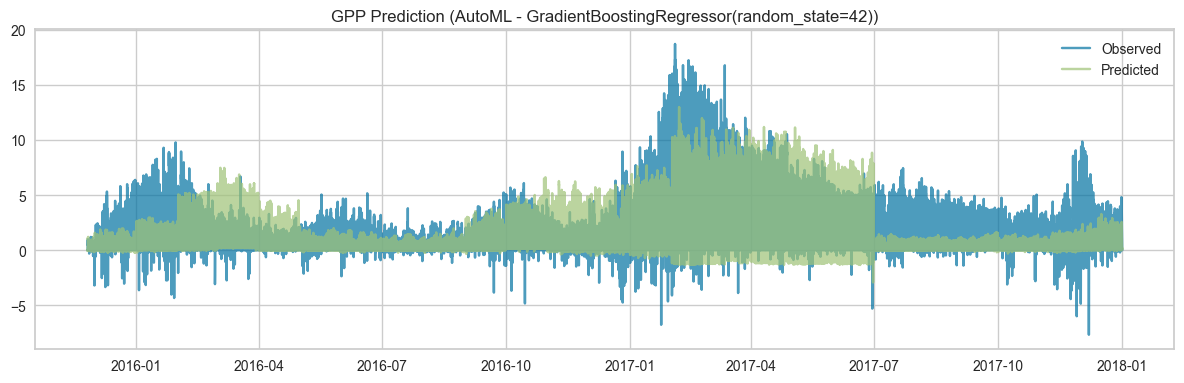


===================== [AutoML - NEE] =====================


,Description,Value
0,Session id,42
1,Target,NEE
2,Target type,Regression
3,Original data shape,"(85914, 16)"
4,Transformed data shape,"(85914, 13)"
5,Transformed train set shape,"(85828, 13)"
6,Transformed test set shape,"(86, 13)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.5234,0.6892,0.8250,0.4425,0.3328,4.3837,5.6233
lightgbm,Light Gradient Boosting Machine,0.5557,0.7610,0.8674,0.3783,0.3439,4.3240,0.3133
et,Extra Trees Regressor,0.5603,0.7747,0.8776,0.3499,0.3417,4.2243,1.8167
catboost,CatBoost Regressor,0.5923,0.8087,0.8966,0.3159,0.3506,5.1812,1.4100
ada,AdaBoost Regressor,0.7181,0.9550,0.9714,0.2343,0.4154,8.1798,1.1900
rf,Random Forest Regressor,0.6179,0.9184,0.9575,0.1870,0.3677,4.5882,7.3033
par,Passive Aggressive Regressor,0.6606,1.0407,1.0110,0.1845,0.4238,6.6519,0.0900
xgboost,Extreme Gradient Boosting,0.6769,1.0526,1.0203,-0.0023,0.3852,5.5133,0.1500
dummy,Dummy Regressor,0.7135,1.3549,1.1419,-0.0040,0.5762,1.1079,0.0500
omp,Orthogonal Matching Pursuit,0.7869,1.1855,1.0878,-0.0579,0.4576,9.2026,0.0367


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Best Model: GradientBoostingRegressor(random_state=42)
R² (Coefficient of Determination):   0.6080
RMSE (Root Mean Squared Error):      1.4261
MAE (Mean Absolute Error):           0.9931
ρ (Pearson Correlation Coefficient): 0.8112


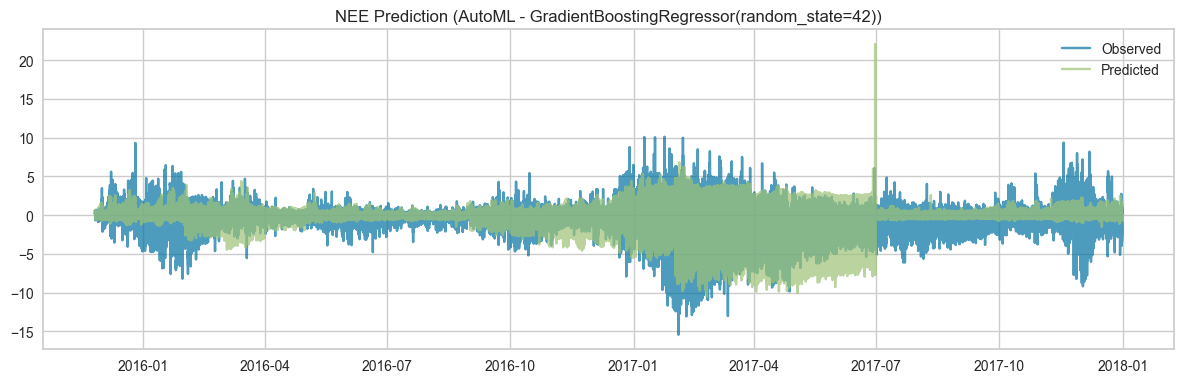

In [10]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pycaret.regression import *
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# --------------------- 1. Load & Preprocess ---------------------
met_ds = xr.open_dataset("AU-ASM_2011-2017_OzFlux_Met.nc")
flux_ds = xr.open_dataset("AU-ASM_2011-2017_OzFlux_Flux.nc")

met_df = met_ds.to_dataframe().reset_index()
flux_df = flux_ds.to_dataframe().reset_index()
df = pd.merge_asof(met_df.sort_values('time'), flux_df.sort_values('time'), on='time')

features_raw = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf', 'Wind',
                'CO2air', 'VPD', 'LAI', 'Ustar']
target_vars = ['GPP', 'NEE']
df = df[['time'] + features_raw + target_vars].dropna()

# 派生特征
df['SW_LAI'] = df['SWdown'] * df['LAI']
df['RH_Tair'] = df['RH'] * df['Tair']
df['SWdown_lag1'] = df['SWdown'].shift(1)
df['Tair_lag1'] = df['Tair'].shift(1)
df = df.dropna()

df = df.set_index('time').sort_index()
features = features_raw + ['SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']

# --------------------- 2. Split Train/Test ---------------------
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# --------------------- 3. AutoML 函数 ---------------------
def run_pycaret_automl(target_var):
    print(f"\n===================== [AutoML - {target_var}] =====================")

    data = pd.concat([train_df[features], train_df[target_var]], axis=1)
    data.reset_index(drop=True, inplace=True)

    # ✅ setup 兼容 PyCaret 3.x 的参数设置
    exp = setup(
        data=data,
        target=target_var,
        session_id=42,
        train_size=0.999,
        fold_strategy='timeseries',
        fold=3,
        fold_shuffle=False,
        data_split_shuffle=False,
        preprocess=True,
        numeric_features=features,
        remove_multicollinearity=True,
        multicollinearity_threshold=0.95
    )

    # 自动模型比较
    best = compare_models(sort='R2')
    
    # 预测 + 指标评估
    test_data = test_df[features].copy().reset_index(drop=True)
    test_target = test_df[target_var].copy().reset_index(drop=True)
    pred = predict_model(best, data=test_data)

    y_pred = pred['prediction_label'].values
    y_true = test_target.values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rho, _ = pearsonr(y_true, y_pred)

    print(f"Best Model: {best}")
    print(f"R² (Coefficient of Determination):   {r2:.4f}")
    print(f"RMSE (Root Mean Squared Error):      {rmse:.4f}")
    print(f"MAE (Mean Absolute Error):           {mae:.4f}")
    print(f"ρ (Pearson Correlation Coefficient): {rho:.4f}")

    # 可视化：预测 vs 实测
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_true, label="Observed", alpha=0.7)
    plt.plot(test_df.index, y_pred, label="Predicted", alpha=0.7)
    plt.title(f"{target_var} Prediction (AutoML - {best})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------- 4. Run ---------------------
run_pycaret_automl('GPP')
run_pycaret_automl('NEE')
